# The Plan:
1.  Pull cluster identities and check for significance?? No time. 
    * Hella complicated. Maybe pulling the angle down to max 2 degrees will help me out?
2.  Statistically significant average azimuth of sun for 8+ magnitude events? Yes
    * ~~Any elegant way to work in the altitude?~~

In [1]:
import requests
import pandas as pd
import json
from datetime import datetime, timedelta
import keys  #Necessary for Astronomy API
import pytz
from timezonefinder import TimezoneFinder
import matplotlib.pyplot as plt
import math
from sklearn.metrics.pairwise import haversine_distances
import pickle
import seaborn as sns
from random import randint, random
from geopy import Point
from geopy.distance import geodesic
import numpy as np
from scipy.stats import ttest_ind

# Define Functions

In [2]:
def get_earthquakes(paramlist):
    paramstring = ''
    for parameter in paramlist:
        paramstring += parameter+'&'
    url_eq = f'https://earthquake.usgs.gov/fdsnws/event/1/query?{paramstring[:-1]}'
    response_eq = requests.get(url_eq)
    
    if response_eq.status_code == 200:
        response_eq_json = response_eq.json()
        
        return response_eq_json
    
    else:
        print(response_eq.status_code)
        return response_eq

In [3]:
def data_to_df(data):

    mags = []
    times = []
    latitudes = []
    longitudes = []
    depths = []
    ids = []
    major_indexes = []
    
    try:
        for feature in data['features']:
            mags.append(feature['properties']['mag'])
            times.append(datetime.fromtimestamp(feature['properties']['time']/1000))
            latitudes.append(feature['geometry']['coordinates'][1])
            longitudes.append(feature['geometry']['coordinates'][0])
            depths.append(feature['geometry']['coordinates'][2])
            ids.append(feature['id'])
        
    except:
        for event in data:
            for feature in data[event]['features']:
                mags.append(feature['properties']['mag'])
                times.append(datetime.fromtimestamp(feature['properties']['time']/1000))
                latitudes.append(feature['geometry']['coordinates'][1])
                longitudes.append(feature['geometry']['coordinates'][0])
                depths.append(feature['geometry']['coordinates'][2])
                ids.append(feature['id'])
                major_indexes.append(int(event.split('_')[1]))

    eq_df = pd.DataFrame({'magnitude': mags, 
                          'time': times,
                          'latitude': latitudes,
                          'longitude': longitudes,
                          'depth': depths,
                          'id': ids})
     
    if len(major_indexes) > 0:
        eq_df['major_index'] = major_indexes
    eq_df.drop_duplicates(keep='first', inplace=True)
    return eq_df

In [4]:
# Designed to work in tandom with output of data_to_df() and parameters of get_earthquakes()

def get_associate_quakes(df, maxmag, window_days=180, radius=100, minmag=2.5):
    asc_quakes = {}
    failures_list = []
    eq_call_failures = {}
    
    
    for i, row in df.iterrows():

        window = timedelta(days=window_days)
        ending = row['time']
        starting = ending - window
        latitude = row['latitude']
        longitude = row['longitude']
        maxmag -= 0.00001

        paramlist_associate_quakes = [
                    'format=geojson',
                    f'minmagnitude={minmag}',
                    'eventtype=earthquake',
                    f'starttime={str(starting).split()[0]}',
                    f'endtime={str(ending).split()[0]}',
                    f'latitude={latitude}',
                    f'longitude={longitude}',
                    f'maxradiuskm={radius}',
                    f'maxmagnitude={maxmag}'
                    ]
        asc_quakes[f'Event_{i}'] = get_earthquakes(paramlist_associate_quakes)
        if type(asc_quakes[f'Event_{i}']) != dict:
            failures_list.append(f'Event_{i}')
    for case in failures_list:
        eq_call_failures[case] = asc_quakes.pop(case)
    return asc_quakes, eq_call_failures

In [5]:
# Designed to work in tandom with outputs of get_associate_quakes(), output of data_to_df(), and parameters of get_earthquakes()

def second_chance(data, failures, df, minmagnitude):
    new_call_failures = []
    for call in failures.keys():
        l = int(call.split('_')[1])
        new_quakes, new_failures = get_associate_quakes(df.iloc[l].to_frame().T, minmagnitude)
        if len(new_failures) == 0:
            data.update(new_quakes)
        else:
            print(f'Ouch. {call}')
            new_call_failures.append(call)
    return data, new_call_failures

In [6]:
# Designed to work in tandom with parameters and output from get_associate_quakes(). n should be have rough parity with size of core earthquake data (length of output from get_associate_quakes()).

def generate_controls(data, n, window_days=180, radius=100):
    window_seconds = window_days*86400
    while True:
        try:
            n = int(n)
            break
        except:
            n = input('n should be a non-negative integer: ')
    control_core = {'Control_0':{'features':[]}}
    for i in range(n):   
        new_date = randint(315532800000, 1677143281000)
        new_lat = randint(-900000, 900000)/10000
        new_lon = randint(-1800000, 1800000)/10000
        control_core['Control_0']['features'].append({'properties':{'time': new_date, 'mag': 0.0}, 'geometry':{'coordinates':[new_lon, new_lat, 1]}, 'id':f'Control{i}'})
        
    
    # Find average number of events associated with each core event
    big_count = 0
    for event in data:
        big_count += data[event]['metadata']['count']
    avg_asc = big_count/len(data)

    dist = np.random.normal(loc=avg_asc, scale=1.0, size=n) # Normal distribution around found average

    # Generate associates for core of control data
    control_list = [f'Control_{i}' for i in range(len(control_core['Control_0']['features']))]
    control_asc = {}
    for l in control_list:
        control_asc[l] = {'features':[]} 
    for i, feature in enumerate(control_core['Control_0']['features']):
        old_time = feature['properties']['time']
        old_point = Point(feature['geometry']['coordinates'][1], feature['geometry']['coordinates'][0])

        sample = randint(0, n-1)
        associates = int(dist[sample])

        for j in range(associates):
            new_time = randint(old_time-window_seconds, old_time-3600)  # 1 hour gap to prevent direct overlap with seed event
            new_point = generate_point(old_point, radius)

            control_asc[f'Control_{i}']['features'].append({'properties':{'time':new_time, 'mag': 0.0}, 'geometry':{'coordinates':[new_point[1], new_point[0], 1]}, 'id':f'Control{i}_{j}'})

    return control_core, control_asc


# Solution for generating random point within radius of central point provided by StackOverflow user nikojpapa
# https://stackoverflow.com/questions/31192451/generate-random-geo-coordinates-within-specific-radius-from-seed-point
# To be called by generate_controls()

def generate_point(center: Point, radius: int) -> Point:
    random_distance = random() * radius
    random_bearing = random() * 360
    return geodesic(kilometers=random_distance).destination(center, random_bearing)

In [7]:
# Designed to accept outputs of get_earthquakes() and get_associate_quakes()

def get_timezones(earthquakes):
    for event in earthquakes:
        for feature in earthquakes[event]['features']:
            lon_lat = feature['geometry']['coordinates']

            event_time = feature['properties']['time']
            event_time = datetime.fromtimestamp(event_time/1000) #Call for local time to avoid confusing the computer later when converting
            
            #Identify timezone
            try:
                tf = TimezoneFinder()
                event_timezone = tf.timezone_at(lat=lon_lat[1], lng=lon_lat[0])
                
                #If timezone cannot be found: send notice, set to None and move on
                if event_timezone == None or event_timezone == 'uninhabited':
                    print(f'Cannot determine timezone for event {feature["id"]}. Flag one')
                    feature['properties']['tz'] = None
                    feature['properties']['local_time'] = None
                    continue
                # Otherwise convert to timezone object and get a local time
                else:
                    event_timezone = pytz.timezone(event_timezone)  #Make timezone into timezone object
                    feature['properties']['tz'] = event_timezone
                    feature['properties']['local_time'] = event_time.astimezone(event_timezone)
            #If timezone cannot be found: send notice, set to None and move on
            except:
                print(f'Cannot determine timezone for event {feature["id"]}. Flag two')
                feature['properties']['tz'] = None
                feature['properties']['local_time'] = None
                continue

            #If timezone cannot be found: send notice, set to None and move on
            if event_timezone == None or event_timezone == 'uninhabited':
                print(f'Timezone issues for event {feature["id"]}. Flag three')
                feature['properties']['tz'] = None
                feature['properties']['local_time'] = None
                continue
    return earthquakes   

In [8]:
# Designed to work with output of get_timezones()

headers_ast = {'Authorization': f"Basic {keys.id_hash}"}

def find_planets(earthquakes, headers_ast=headers_ast):
    for event in earthquakes:
        for feature in earthquakes[event]['features']:
            lon_lat = feature['geometry']['coordinates']
            event_time = feature['properties']['local_time']
            
            #Convert to local time of event and parse for readability by AstronomyAPI
            try:
                event_time = event_time.strftime('%Y-%m-%d#%H%%3A%M%%3A%S').split('#')
            except:
                continue

            # Depth cannot be included in AstronomyAPI call: instance.elevation must be greater than or equal to 0
            url_ast = f"https://api.astronomyapi.com/api/v2/bodies/positions?longitude={lon_lat[0]}&latitude={lon_lat[1]}&elevation=0&from_date={event_time[0]}&to_date={event_time[0]}&time={event_time[1]}"
            response_ast = requests.get(url_ast, headers=headers_ast)
            
            try:
                response_ast_json = response_ast.json()
                #Hang astronomy information onto event information
                feature['astronomy'] = response_ast_json

            except:
                print(f'Cannot gather planetary info for event {feature["id"]}: {response_ast.status_code}')
                feature['astronomy'] = {}
    return earthquakes

In [9]:
# Designed to avoid overwhelming AstronomyAPI with too many requests at once. Works with output of find_planets()

def mini_grab(data, master_list, master_number):
    mini_catalog = {}
    if master_number < len(master_list):
        print(master_number)
        for event in master_list[master_number]:
            mini_catalog[event] = data[event]
        mini_catalog = find_planets(mini_catalog)
        master_number += 1
        data.update(mini_catalog)
    
    return data, master_number

In [10]:
#Function to reduce size of data-set, keeping only relevant information for this analysis

def organize_data(quakes_and_planets):
    events = {}
    for i, event in enumerate(quakes_and_planets):
        intro = str(event).split('_')[0]
        for j, feature in enumerate(quakes_and_planets[event]['features']):
            if len(quakes_and_planets) == 1:
                k = str(j)
            else:
                k = f'{i}_{j}'
            
            events[f'{intro}_{k}'] = {}
            events[f'{intro}_{k}']['local_time'] = feature['properties']['local_time'].strftime('%Y-%m-%d#%X') #Local event time
            events[f'{intro}_{k}']['coordinates'] = feature['geometry']['coordinates'] #Event coordinates
            events[f'{intro}_{k}']['magnitude'] = feature['properties']['mag'] #Event magnitude

            events[f'{intro}_{k}']['astronomy'] = {}
            if len(feature['astronomy']) == 0:
                continue
            else:
                for p in range(11):
                    if p == 4:  #skip 4 earth
                        continue
                    else:
                        name = feature['astronomy']['data']['table']['rows'][p]['cells'][0]['name'] #Body name
                        events[f'{intro}_{k}']['astronomy'][name] = {}
                        events[f'{intro}_{k}']['astronomy'][name]['distance'] = float(feature['astronomy']['data']['table']['rows'][p]['cells'][0]['distance']['fromEarth']['au']) #Body distance from earth in AU
                        events[f'{intro}_{k}']['astronomy'][name]['altitude'] = float(feature['astronomy']['data']['table']['rows'][p]['cells'][0]['position']['horizontal']['altitude']['degrees']) #Body altitude in decimal degrees
                        events[f'{intro}_{k}']['astronomy'][name]['azimuth'] = float(feature['astronomy']['data']['table']['rows'][p]['cells'][0]['position']['horizontal']['azimuth']['degrees']) #Body azimuth in decimal degrees
    return events

In [11]:
# Deprecated during course of analysis
# See associated major event and precursors at a glace

def associate(n, df1, df2):
    pd.concat([df1.iloc[n].to_frame().T, df2.loc[df2['major_index'] == n]])

In [12]:
# Designed to work with output of organize_data()

def find_separations(data):
    for event in data:
        # print(event)
        for body_1 in data[event]['astronomy']:
            data[event]['astronomy'][body_1]['separations'] = {}
            for body_2 in data[event]['astronomy']:
                if body_1 == body_2:
                    continue
                data[event]['astronomy'][body_1]['separations'][body_2] = math.degrees(                                                      # Return result to degrees
                    haversine_distances([                                                                                                    # Pairwise method for finding separation by radians of two points on spherical surface
                    [math.radians(data[event]['astronomy'][body_1]['altitude']), math.radians(data[event]['astronomy'][body_1]['azimuth'])], # Convert altitude and azimuth of each body to radians
                    [math.radians(data[event]['astronomy'][body_2]['altitude']), math.radians(data[event]['astronomy'][body_2]['azimuth'])]
                    ])[1][0]                                                                                                                 # Keep only one copy of result
                    )
    return data

In [13]:
# Designed to work with output of find_planets(), organize_data(), or find_separations()

def plot_event(event):
        plt.clf()
        bodies = [body for body in event['astronomy']]

        r = []
        for body in bodies:
            r.append(math.log10(event['astronomy'][body]['distance']))

        theta = []
        # theta_see = []
        for body in bodies:
            theta.append(math.radians(event['astronomy'][body]['azimuth']))

        fig = plt.figure()
        ax = fig.add_subplot(projection='polar')
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_yticklabels([])
        for i, body in enumerate(bodies):
            ax.annotate(body, (theta[i], r[i]))

        ax.scatter(theta, r)
        
        plt.show();


In [14]:
# Designed to work with output of find_separations()

def count_alignments(data, include_90=False):
    alignments = pd.DataFrame(index=[event for event in data], columns=list(reversed([i for i in range(1,13)])))

    for event in data:
        v = 12
        while v > 0:
            aligned = set()
            for body in data[event]['astronomy']:
                for partner in data[event]['astronomy'][body]['separations']:
                    if (data[event]['astronomy'][body]['separations'][partner] <= v or 
                        data[event]['astronomy'][body]['separations'][partner] >= 180-v):
                        aligned.add(partner)
                    elif (include_90 == True and
                    90-v/2 <= data[event]['astronomy'][body]['separations'][partner] <= 90+v/2):
                        aligned.add(partner)
                        
            alignments.loc[event, v] = len(aligned)
            v -= 1

    return alignments

So I need to, rather than just identify how many bodies have a spacial association with another, but to place them into clusters and see if the number of clusters matter

Practically, the first two bodies should join a set. A third body should join that set only if it displays a relation to **both** bodies in the set, and so on.
What if a body shows a relation to one but not the other? We have here a wide-angle problem, and one should be dropped - *but which*?    
It has been decided to build a custom list to interate through bodies, thereby giving priority to those of greater supposed influence. This influence arises from a confluence of distance from earth and bodily mass.
We then must build other clusters according to neccessity.

In [15]:
# Designed to be called by count_clusters() or identify_clusters()

def assign_cluster(data, body, partner, v, groupings, include_90=False):
    for cluster in groupings:
        if partner in cluster:
            break
        
        elif len(cluster) == 0:
            cluster.update([body, partner])
            break
        
        else:
            check_sum = 0
            for member in cluster:
                if (data[member]['separations'][partner] <= v or 
                data[member]['separations'][partner] >= 180-v):
                    check_sum += 1
                
                elif (include_90 == True and
                90-v/2 <= data[member]['separations'][partner] <= 90+v/2):
                    check_sum += 1
            
            if check_sum == len(cluster):
                cluster.add(partner)
                break
    return groupings

In [16]:
# Designed to work with output of find_separations()

def count_clusters(data, include_90=False):
    clusters = pd.DataFrame(index=[event for event in data], columns=list(reversed([i for i in range(1,13)])))
    
    for event in data:
            v = 12
            
            while v > 0:
                a = set()
                b = set()
                c = set()
                d = set()
                e = set()
                groupings = [a, b, c, d, e]
                
                for body in ['Sun', 'Moon', 'Jupiter', 'Saturn', 'Venus', 'Mars', 'Mercury', 'Uranus', 'Neptune', 'Pluto']:  #Manually defined list to prioritize by supposed influence
                    
                    for partner in data[event]['astronomy'][body]['separations']:
                        
                        if (data[event]['astronomy'][body]['separations'][partner] <= v or 
                        data[event]['astronomy'][body]['separations'][partner] >= 180-v):
                            
                            groupings = assign_cluster(data[event]['astronomy'], body, partner, v, groupings)
                        
                        elif (include_90 == True and
                        90-v/2 <= data[event]['astronomy'][body]['separations'][partner] <= 90+v/2):
                            
                            groupings = assign_cluster(data[event]['astronomy'], body, partner, v, groupings, include_90)
                
                
                n = 0
                for cluster in groupings:
                    if len(cluster) > 0:
                        n += 1
                clusters.loc[event, v] = n
                v -= 1
    
    return clusters

In [17]:
# Designed to work with output of find_separations()

def identify_clusters(data, include_90=False):
    clusters = pd.DataFrame(index=[event for event in data], columns=list(reversed([i for i in range(1,13)])))
    
    for event in data:
        v = 12

        while v > 0:
            a = set()
            b = set()
            c = set()
            d = set()
            e = set()
            groupings = [a, b, c, d, e]

            for body in ['Sun', 'Moon', 'Jupiter', 'Saturn', 'Venus', 'Mars', 'Mercury', 'Uranus', 'Neptune', 'Pluto']:  #Manually defined list to prioritize by supposed influence
                
                for partner in data[event]['astronomy'][body]['separations']:

                    if (data[event]['astronomy'][body]['separations'][partner] <= v or 
                    data[event]['astronomy'][body]['separations'][partner] >= 180-v):

                        groupings = assign_cluster(data[event]['astronomy'], body, partner, v, groupings)

                    elif (include_90 == True and
                    90-v/2 <= data[event]['astronomy'][body]['separations'][partner] <= 90+v/2):

                        groupings = assign_cluster(data[event]['astronomy'], body, partner, v, groupings, include_90)

            clusters.loc[event, v] = groupings
            v -= 1
    
    return clusters

In [18]:
# Designed to work with output of find_separations()

def make_azimuth_df(data):
    mags = []
    times = []
    coord = []
    Sun = []
    Moon = []
    Jupiter = []
    Saturn = []
    indexes = []
    for event in data:
        mags.append(data[event]['magnitude'])
        indexes.append(event)
        times.append(data[event]['local_time'])
        coord.append(data[event]['coordinates'])
        Sun.append(data[event]['astronomy']['Sun']['azimuth'])
        Moon.append(data[event]['astronomy']['Moon']['azimuth'])
        Jupiter.append(data[event]['astronomy']['Jupiter']['azimuth'])
        Saturn.append(data[event]['astronomy']['Saturn']['azimuth'])
    return pd.DataFrame({'magnitude': mags, 'local_time': times, 'coordinates': coord, 'Sun': Sun, 'Moon': Moon, 'Jupiter': Jupiter, 'Saturn': Saturn}, index=indexes)

In [19]:
# Designed to work with output of find_separations()

def make_altitude_df(data):
    mags = []
    times = []
    coord = []
    Sun = []
    Moon = []
    Jupiter = []
    Saturn = []
    indexes = []
    for event in data:
        mags.append(data[event]['magnitude'])
        indexes.append(event)
        times.append(data[event]['local_time'])
        coord.append(data[event]['coordinates'])
        Sun.append(data[event]['astronomy']['Sun']['altitude'])
        Moon.append(data[event]['astronomy']['Moon']['altitude'])
        Jupiter.append(data[event]['astronomy']['Jupiter']['altitude'])
        Saturn.append(data[event]['astronomy']['Saturn']['altitude'])
    return pd.DataFrame({'magnitude': mags, 'local_time': times, 'coordinates': coord, 'Sun': Sun, 'Moon': Moon, 'Jupiter': Jupiter, 'Saturn': Saturn}, index=indexes)

In [20]:
# Designed to work with output of find_separations()

def make_sun_separations_df(data):
    indexes = []
    mags = []
    times = []
    coord = []
    Moon = []
    Jupiter = []
    Saturn = []
    for event in data:
            mags.append(data[event]['magnitude'])
            indexes.append(event)
            times.append(data[event]['local_time'])
            coord.append(data[event]['coordinates'])
            Moon.append(data[event]['astronomy']['Sun']['separations']['Moon'])
            Jupiter.append(data[event]['astronomy']['Sun']['separations']['Jupiter'])
            Saturn.append(data[event]['astronomy']['Sun']['separations']['Saturn'])
    return pd.DataFrame({'magnitude': mags, 'local_time': times, 'coordinates': coord, 'Moon': Moon, 'Jupiter': Jupiter, 'Saturn': Saturn}, index=indexes)

# Gather Earthquake Data

In [21]:
startdate = '1980-01-01'
minmagnitude = 7

paramlist_core_quakes = [
            'format=geojson',
            f'minmagnitude={minmagnitude}',
            'eventtype=earthquake',
            f'starttime={startdate}'
            ]

# eq_data = get_earthquakes(paramlist_core_quakes)

# eq_data = {'Event_0': eq_data}  #Give data same architecture as upcoming associate data

# with open('./core_quakes.pickle', 'wb') as f:
#     pickle.dump(eq_data, f)

In [22]:
# with open('./core_quakes.pickle', 'rb') as f:
#     core_eq_data = pickle.load(f)

In [23]:
# core_eq_df = data_to_df(core_eq_data)
# core_eq_df

In [24]:
window_days = 180
radius = 100
minmag = 2.5

# asc_eq_data = get_associate_quakes(eq_df, minmagnitude)

# with open('./asc_quakes.pickle', 'wb') as f:
#     pickle.dump(asc_eq_data, f)

In [25]:
# with open('./asc_quakes.pickle', 'rb') as f:
#     asc_eq_data = pickle.load(f)

In [26]:
# Check if each major event has associated events

# for n in core_eq_df.index:
#     if len(asc_eq_data[f'Event_{n}']['features']) == 0:
#         print(f'Event_{n}')

In [27]:
# Get timezone information for each data set

# timed = get_timezones(core_eq_data)
# with open('./timed_core_quakes.pickle', 'wb') as f:
#     pickle.dump(timed, f)
# timed = get_timezones(asc_eq_data)
# with open('./timed_asc_quakes.pickle', 'wb') as f:
#     pickle.dump(timed, f)

In [28]:
# Check for local times for each event

# for event in timed:
#     for feature in timed[event]['features']:
#         if type(feature['properties']['local_time'])  != datetime:
#             print(f'{event}: {feature["id"]}')
#         else:
#             continue

# Generate Control

In keeping with the null hypothesis that earthquakes are random in time and space, control data will be built in a manner mirroring the data collection process.
First, we select the size of the seeding set, equivalent to the core events of magnitude 7.0 or greater. 750 was chosen for being in the league of and slightly larger than our core data of 611 events.
Next, for each seed generated, we randomly generate a number of associated events to be generated within a 6 month window and 100 km radius of the seed.
This number of associated events is randomly selected from a normal distribution of 750 numbers centered around 26.0, which is the average number of events associated to each member of the core data set.

In [29]:
# control_core, control_asc = generate_controls(asc_eq_data, 750)

In [30]:
# with open('./control_core.pickle', 'wb') as f:
#     pickle.dump(control_core, f)
# with open('./control_asc.pickle', 'wb') as f:
#     pickle.dump(control_asc, f)

In [31]:
# control_core = get_timezones(control_core)
# control_asc = get_timezones(asc_core)

# Gather Astronomy Data

In [32]:
# with open('./timed_core_quakes.pickle','rb') as f:
#     core_quakes = pickle.load(f)
# with open('./control_core.pickle', 'rb') as f:
#     control_core = pickle.load(f)

In [33]:
# core_and_planets = find_planets(core_quakes)
# control_core_and_planets = find_planets(control_core)

In [34]:
# with open('./core_quakes_and_planets.pickle', 'wb') as f:
#     pickle.dump(core_and_planets, f)
# with open('./control_core_and_planets.pickle', 'wb') as f:
#     pickle.dump(control_core_and_planets, f)

In [35]:
# with open('./core_quakes_and_planets.pickle', 'rb') as f:
#     core_and_planets = pickle.load(f)
# with open('./control_core_and_planets.pickle', 'rb') as f:
#     control_core_and_planets = pickle.load(f)

In [36]:
# Check if each quake has astronomy data

# for i, feature in enumerate(core_and_planets['Event_0']['features']):
#     if len(feature['astronomy']) == 0:
#         print(f'Investigate event {i}')
    # else:
    #     print(f'This many planets? {len(feature["astronomy"]["data"]["table"]["rows"])}')

In [37]:
# How many major events can I run through and not break AstronomyAPI?

# i = 100
# n = 0
# for j, event in enumerate(asc_eq_data):
#         n += asc_eq_data[event]['metadata']['count']
#         if n > 800:
#             break
# j

In [38]:
# with open('./timed_asc_quakes.pickle', 'rb') as f:
#     asc_and_planets = pickle.load(f)

In [39]:
# with open('./asc_quakes_and_planets.pickle', 'rb') as f:
#     asc_and_planets = pickle.load(f)

# If resuming after a fresh load, set master_number to pick up at leaving off point
# Last master_number used will have been printed as output of mini_grab()
# master_number = 0

In [40]:
# asc_and_planets[f'Event_{master_number*34-1}']
# asc_and_planets['Event_610']

In [41]:
# Master list for associate data

# master_list = []
# sub_list = []

# for i in range(len(asc_and_planets)):
#     sub_list.append(f'Event_{i}')
#     if i%34 == 33:
#         master_list.append(sub_list.copy())
#         sub_list.clear()
#     elif i == len(asc_and_planets)-1:
#         master_list.append(sub_list.copy())

In [42]:
# asc_and_planets, master_number = mini_grab(asc_and_planets, master_list, master_number)

In [43]:
# with open('./asc_quakes_and_planets.pickle', 'wb') as f:
#     pickle.dump(asc_and_planets, f)

In [44]:
# with open('./control_asc_and_planets.pickle', 'rb') as f:
#     control_asc_and_planets = pickle.load(f)
    
# master_number = 0

In [45]:
# Master list for associate control data

# master_list = []
# sub_list = []

# for i in range(len(control_asc_and_planets)):
#     sub_list.append(f'Control_{i}')
#     if i%34 == 33:
#         master_list.append(sub_list.copy())
#         sub_list.clear()
#     elif i == len(control_asc_and_planets)-1:
#         master_list.append(sub_list.copy())

In [46]:
# control_asc_and_planets, master_number = mini_grab(control_asc_and_planets, master_list, master_number)

In [47]:
# Check if each quake has astronomy data

# for i, event in enumerate(control_core_and_planets):
#     for j, feature in enumerate(control_core_and_planets[event]['features']):
#         if len(feature) != 0 and len(feature['astronomy']) == 0:
#             print(f'Investigate event {i}_{j}')
#             print(len(control_core_and_planets[event]['features']))
#         if feature['astronomy']['message'] == 'none':
#             print(f'Investigate event {i}_{j}')

In [48]:
# One last check to make sure some core events have no associates within assigned window

# to_investigate = []
# for i, event in enumerate(asc_and_planets):
#     if len(asc_and_planets[event]['features']) == 0:
#         print(f'Investigate event {i}')
#         to_investigate.append(i)

# core_df = data_to_df(core_and_planets)
# investigate_df = core_df.loc[core_df.index.isin(to_investigate)]
# investigation_data = get_associate_quakes(investigate_df, minmagnitude)
# investigation_data = investigation_data[0]
# for event in investigation_data:
#     if investigation_data[event]['metadata']['count'] != 0:
#         print(event)

# Find body separations and look for clusters

In [49]:
with open('./core_quakes_and_planets.pickle', 'rb') as f:
    core_and_planets = pickle.load(f)
with open('./asc_quakes_and_planets.pickle', 'rb') as f:
    asc_and_planets = pickle.load(f)
with open('./control_core_and_planets.pickle', 'rb') as f:
    control_core_and_planets = pickle.load(f)
with open('./control_asc_and_planets.pickle', 'rb') as f:
    control_asc_and_planets = pickle.load(f)

In [50]:
organized_core = organize_data(core_and_planets)
organized_asc = organize_data(asc_and_planets)
core_with_separations = find_separations(organized_core)
asc_with_separations = find_separations(organized_asc)
organized_control_core = organize_data(control_core_and_planets)
control_core_with_separations = find_separations(organized_control_core)
organized_control_asc = organize_data(control_asc_and_planets)
control_asc_with_separations = find_separations(organized_control_asc)

In [51]:
core_alignments = count_alignments(core_with_separations)
asc_alignments = count_alignments(asc_with_separations)

In [52]:
control_core_alignments = count_alignments(control_core_with_separations)
control_asc_alignments = count_alignments(control_asc_with_separations)

In [53]:
simple_alignments = pd.concat([core_alignments, asc_alignments])

simple_alignments_ratios = pd.DataFrame(index=range(1,13), columns=[f'{i} Clustered' for i in range(11)])
for n in range(11):
    for column in simple_alignments.columns:
        m = simple_alignments.loc[simple_alignments[column] == n].count()[column]
        simple_alignments_ratios.iloc[column-1, n] = round(m*100/simple_alignments.count()[1], 3)
simple_alignments_ratios.index.name = 'Deg of separation'
# simple_alignments_ratios.drop(columns='1 Clustered')

In [54]:
control_simple_alignments = pd.concat([control_core_alignments, control_asc_alignments])

control_simple_alignments_ratios = pd.DataFrame(index=range(1,13), columns=[f'{i} Clustered' for i in range(11)])
for n in range(11):
    for column in control_simple_alignments.columns:
        m = control_simple_alignments.loc[control_simple_alignments[column] == n].count()[column]
        control_simple_alignments_ratios.iloc[column-1, n] = round(m*100/control_simple_alignments.count()[1], 3)
control_simple_alignments_ratios.index.name = 'Deg of separation'
# control_simple_alignments_ratios.drop(columns='1 Clustered')

In [55]:
core_alignments_90 = count_alignments(core_with_separations, include_90=True)
asc_alignments_90 = count_alignments(asc_with_separations, include_90=True)

In [56]:
control_core_alignments_90 = count_alignments(control_core_with_separations, include_90=True)
control_asc_alignments_90 = count_alignments(control_asc_with_separations, include_90=True)

In [57]:
simple_alignments_90 = pd.concat([core_alignments_90, asc_alignments_90])

simple_alignments_90_ratios = pd.DataFrame(index=range(1,13), columns=[f'{i} Clustered' for i in range(11)])
for n in range(11):
    for column in simple_alignments_90.columns:
        m = simple_alignments_90.loc[simple_alignments_90[column] == n].count()[column]
        simple_alignments_90_ratios.iloc[column-1, n] = round(m*100/simple_alignments_90.count()[1], 3)
simple_alignments_90_ratios.index.name = 'Deg of separation'
# simple_alignments_90_ratios.drop(columns='1 Clustered')

In [58]:
control_simple_alignments_90 = pd.concat([control_core_alignments_90, control_asc_alignments_90])

control_simple_alignments_90_ratios = pd.DataFrame(index=range(1,13), columns=[f'{i} Clustered' for i in range(11)])
for n in range(11):
    for column in control_simple_alignments_90.columns:
        m = control_simple_alignments_90.loc[control_simple_alignments_90[column] == n].count()[column]
        control_simple_alignments_90_ratios.iloc[column-1, n] = round(m*100/control_simple_alignments_90.count()[1], 3)
control_simple_alignments_90_ratios.index.name = 'Deg of separation'
# control_simple_alignments_90_ratios.drop(columns='1 Clustered')

In [59]:
core_clusters = count_clusters(core_with_separations)
asc_clusters = count_clusters(asc_with_separations)

In [60]:
control_core_clusters = count_clusters(control_core_with_separations)
control_asc_clusters = count_clusters(control_asc_with_separations)

In [61]:
simple_clustering = pd.concat([core_clusters, asc_clusters])

simple_clustering_ratios = pd.DataFrame(index=range(1,13), columns=[f'{i} uClusters' for i in range(6)])
for n in range(6):
    for column in simple_clustering.columns:
        m = simple_clustering.loc[simple_clustering[column] == n].count()[column]
        simple_clustering_ratios.iloc[column-1, n] = round(m*100/simple_clustering.count()[1], 3)
simple_clustering_ratios.index.name = 'Deg of separation'
# simple_clustering_ratios

In [62]:
control_simple_clustering = pd.concat([control_core_clusters, control_asc_clusters])

control_simple_clustering_ratios = pd.DataFrame(index=range(1,13), columns=[f'{i} uClusters' for i in range(6)])
for n in range(6):
    for column in control_simple_clustering.columns:
        m = control_simple_clustering.loc[control_simple_clustering[column] == n].count()[column]
        control_simple_clustering_ratios.iloc[column-1, n] = round(m*100/control_simple_clustering.count()[1], 3)
control_simple_clustering_ratios.index.name = 'Deg of separation'
# control_simple_clustering_ratios

In [63]:
core_clusters_90 = count_clusters(core_with_separations, include_90=True)
asc_clusters_90 = count_clusters(asc_with_separations, include_90=True)

In [64]:
control_core_clusters_90 = count_clusters(control_core_with_separations, include_90=True)
control_asc_clusters_90 = count_clusters(control_asc_with_separations, include_90=True)

In [65]:
simple_clustering_90 = pd.concat([core_clusters_90, asc_clusters_90])

simple_clustering_90_ratios = pd.DataFrame(index=range(1,13), columns=[f'{i} uClusters' for i in range(6)])
for n in range(6):
    for column in simple_clustering_90.columns:
        m = simple_clustering_90.loc[simple_clustering_90[column] == n].count()[column]
        simple_clustering_90_ratios.iloc[column-1, n] = round(m*100/simple_clustering_90.count()[1], 3)
simple_clustering_90_ratios.index.name = 'Deg of separation'
# simple_clustering_90_ratios

In [66]:
control_simple_clustering_90 = pd.concat([control_core_clusters_90, control_asc_clusters_90])

control_simple_clustering_90_ratios = pd.DataFrame(index=range(1,13), columns=[f'{i} uClusters' for i in range(6)])
for n in range(6):
    for column in control_simple_clustering_90.columns:
        m = control_simple_clustering_90.loc[control_simple_clustering_90[column] == n].count()[column]
        control_simple_clustering_90_ratios.iloc[column-1, n] = round(m*100/control_simple_clustering_90.count()[1], 3)
control_simple_clustering_90_ratios.index.name = 'Deg of separation'
# control_simple_clustering_ratios_90

In [67]:
# Check that clusters for particular seperation regimes sum to unity
# for i in range(12):
#     print(simple_clustering_ratios.iloc[i].sum())

# Investigate magnitude

In [68]:
# Look at four major bodies
# Set sun as 0deg
# Check separations and look for pattern
# Extremely high std indicates no likely pattern
# Bodies appear normally distributed, though Jupiter leans a bit left (still with slightly higher std)
# Histograms reveal Saturn sits a bit more towards opposition

indexes = []
mags = []
p0 = []
p1 = []
p2 = []
p3 = []
# p4 = []

for event in core_with_separations:
    indexes.append(event)
    mags.append(core_with_separations[event]['magnitude'])
    p0.append(0.0)
    p1.append(core_with_separations[event]['astronomy']['Sun']['separations']['Moon'])
    p2.append(core_with_separations[event]['astronomy']['Sun']['separations']['Jupiter'])
    p3.append(core_with_separations[event]['astronomy']['Sun']['separations']['Saturn'])
for event in asc_with_separations:
    indexes.append(event)
    mags.append(asc_with_separations[event]['magnitude'])
    p0.append(0.0)
    p1.append(asc_with_separations[event]['astronomy']['Sun']['separations']['Moon'])
    p2.append(asc_with_separations[event]['astronomy']['Sun']['separations']['Jupiter'])
    p3.append(asc_with_separations[event]['astronomy']['Sun']['separations']['Saturn'])
    
separation_from_Sun_df = pd.DataFrame({'Magnitude':mags, 'Sun': p0, 'Moon': p1, 'Jupiter':p2, 'Saturn':p3}, index=indexes)

In [69]:
separation_from_Sun_df['Magnitude'] = separation_from_Sun_df.Magnitude.apply(lambda x: int(x))
mean_sep_by_mag = (separation_from_Sun_df.groupby('Magnitude')
                       .agg(Sun=('Sun', 'mean'), 
                        Moon=('Moon', 'mean'), 
                        Jupiter=('Jupiter', 'mean'), 
                        Saturn=('Saturn', 'mean')))

In [70]:
# Look at four major bodies
# Set sun as 0deg
# Check separations and look for pattern
# Extremely high std indicates no likely pattern
# Bodies appear normally distributed, though Jupiter leans a bit left (still with slightly higher std)
# Histograms reveal Saturn sits a bit more towards opposition

indexes = []
mags = []
p0 = []
p1 = []
p2 = []
p3 = []
# p4 = []

for event in control_core_with_separations:
    indexes.append(event)
    mags.append(control_core_with_separations[event]['magnitude'])
    p0.append(0.0)
    p1.append(control_core_with_separations[event]['astronomy']['Sun']['separations']['Moon'])
    p2.append(control_core_with_separations[event]['astronomy']['Sun']['separations']['Jupiter'])
    p3.append(control_core_with_separations[event]['astronomy']['Sun']['separations']['Saturn'])
for event in control_asc_with_separations:
    indexes.append(event)
    mags.append(control_asc_with_separations[event]['magnitude'])
    p0.append(0.0)
    p1.append(control_asc_with_separations[event]['astronomy']['Sun']['separations']['Moon'])
    p2.append(control_asc_with_separations[event]['astronomy']['Sun']['separations']['Jupiter'])
    p3.append(control_asc_with_separations[event]['astronomy']['Sun']['separations']['Saturn'])
    
control_separation_from_Sun_df = pd.DataFrame({'Magnitude':mags, 'Sun': p0, 'Moon': p1, 'Jupiter':p2, 'Saturn':p3}, index=indexes)

In [71]:
control_separation_from_Sun_df['Magnitude'] = control_separation_from_Sun_df.Magnitude.apply(lambda x: int(x))
control_mean_sep_by_mag = (control_separation_from_Sun_df.groupby('Magnitude')
                       .agg(Sun=('Sun', 'mean'), 
                        Moon=('Moon', 'mean'), 
                        Jupiter=('Jupiter', 'mean'), 
                        Saturn=('Saturn', 'mean')))

<Figure size 640x480 with 0 Axes>

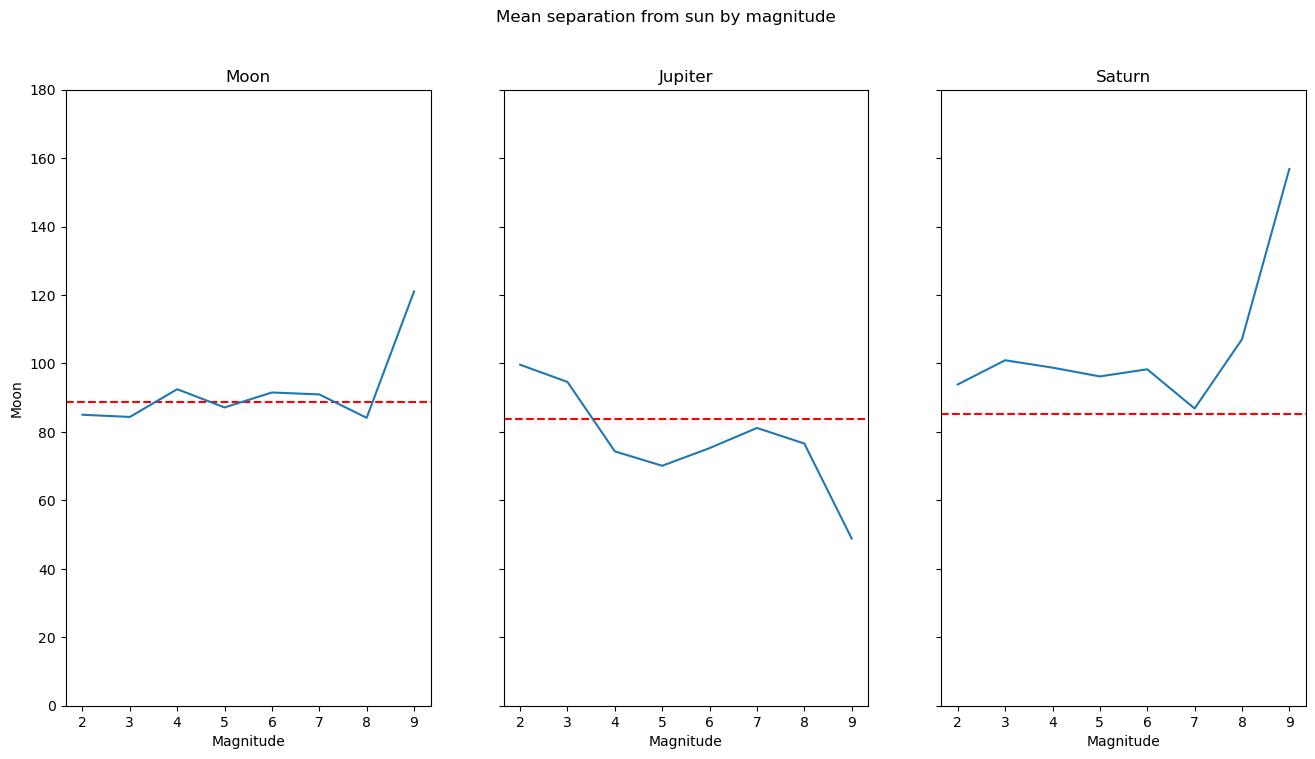

In [72]:
plt.clf()
fig, (ax2, ax3, ax4) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(16,8))
fig.suptitle('Mean separation from sun by magnitude')
# ax1.set_title('Sun')
ax2.set_title('Moon')
ax2.axhline(y=control_mean_sep_by_mag.Moon[0], linestyle='dashed', color='r')
ax3.set_title('Jupiter')
ax3.axhline(y=control_mean_sep_by_mag.Jupiter[0], linestyle='dashed', color='r')
ax4.set_title('Saturn')
ax4.axhline(y=control_mean_sep_by_mag.Saturn[0], linestyle='dashed', color='r')
for ax in [ax2, ax3, ax4]:
    ax.set_ylim(0,180)
# sns.lineplot(ax=ax1, x=mean_sep_by_mag.index, y=mean_sep_by_mag.Sun)
sns.lineplot(ax=ax2, x=mean_sep_by_mag.index, y=mean_sep_by_mag.Moon)
sns.lineplot(ax=ax3, x=mean_sep_by_mag.index, y=mean_sep_by_mag.Jupiter)
sns.lineplot(ax=ax4, x=mean_sep_by_mag.index, y=mean_sep_by_mag.Saturn)
fig.savefig('./Visuals/MeanSeparations.png', format='png')
plt.show();

In [73]:
# Look at four major bodies
# Take azimuth as primary indicator of position
# Extremely high std indicates no likely pattern
# Values appear normally distributed

indexes = []
mags = []
p0 = []
p1 = []
p2 = []
p3 = []
# p4 = []

for event in core_with_separations:
    indexes.append(event)
    mags.append(core_with_separations[event]['magnitude'])
    p0.append(core_with_separations[event]['astronomy']['Sun']['azimuth'])
    p1.append(core_with_separations[event]['astronomy']['Moon']['azimuth'])
    p2.append(core_with_separations[event]['astronomy']['Jupiter']['azimuth'])
    p3.append(core_with_separations[event]['astronomy']['Saturn']['azimuth'])
for event in asc_with_separations:
    indexes.append(event)
    mags.append(asc_with_separations[event]['magnitude'])
    p0.append(asc_with_separations[event]['astronomy']['Sun']['azimuth'])
    p1.append(asc_with_separations[event]['astronomy']['Moon']['azimuth'])
    p2.append(asc_with_separations[event]['astronomy']['Jupiter']['azimuth'])
    p3.append(asc_with_separations[event]['astronomy']['Saturn']['azimuth'])
    
azimuth_df = pd.DataFrame({'Magnitude':mags, 'Sun': p0, 'Moon': p1, 'Jupiter':p2, 'Saturn':p3}, index=indexes)

In [74]:
azimuth_df['Magnitude'] = azimuth_df.Magnitude.apply(lambda x: int(x))
mean_azi_by_mag = (azimuth_df
                   .groupby('Magnitude')
                   .agg(Sun=('Sun', 'mean'), 
                        Moon=('Moon', 'mean'), 
                        Jupiter=('Jupiter', 'mean'), 
                        Saturn=('Saturn', 'mean'))
                    )
mean_azi_by_mag

,Sun,Moon,Jupiter,Saturn
Magnitude,,,,
2,176.836967,172.682845,179.740922,176.731996
3,179.391730,175.662831,178.062699,175.139372
4,175.008124,183.146169,177.438667,181.223948
5,178.440186,187.752925,178.509982,181.088906
6,180.342131,178.590997,177.324296,179.793883
7,181.491899,178.025871,175.560941,176.028763
8,223.966857,215.470286,203.965714,166.088000
9,176.115000,214.485000,225.415000,163.290000


In [75]:
# Look at four major bodies
# Take azimuth as primary indicator of position
# Extremely high std indicates no likely pattern
# Values appear normally distributed

indexes = []
mags = []
p0 = []
p1 = []
p2 = []
p3 = []
# p4 = []

for event in control_core_with_separations:
    indexes.append(event)
    mags.append(control_core_with_separations[event]['magnitude'])
    p0.append(control_core_with_separations[event]['astronomy']['Sun']['azimuth'])
    p1.append(control_core_with_separations[event]['astronomy']['Moon']['azimuth'])
    p2.append(control_core_with_separations[event]['astronomy']['Jupiter']['azimuth'])
    p3.append(control_core_with_separations[event]['astronomy']['Saturn']['azimuth'])
for event in control_asc_with_separations:
    indexes.append(event)
    mags.append(control_asc_with_separations[event]['magnitude'])
    p0.append(control_asc_with_separations[event]['astronomy']['Sun']['azimuth'])
    p1.append(control_asc_with_separations[event]['astronomy']['Moon']['azimuth'])
    p2.append(control_asc_with_separations[event]['astronomy']['Jupiter']['azimuth'])
    p3.append(control_asc_with_separations[event]['astronomy']['Saturn']['azimuth'])
    
control_azimuth_df = pd.DataFrame({'Magnitude':mags, 'Sun': p0, 'Moon': p1, 'Jupiter':p2, 'Saturn':p3}, index=indexes)

In [76]:
control_azimuth_df['Magnitude'] = control_azimuth_df.Magnitude.apply(lambda x: int(x))
control_mean_azi_by_mag = (control_azimuth_df
                   .groupby('Magnitude')
                   .agg(Sun=('Sun', 'mean'), 
                        Moon=('Moon', 'mean'), 
                        Jupiter=('Jupiter', 'mean'), 
                        Saturn=('Saturn', 'mean'))
                    )
control_mean_azi_by_mag

,Sun,Moon,Jupiter,Saturn
Magnitude,,,,
0,175.203872,180.860709,179.927507,181.917357


<Figure size 640x480 with 0 Axes>

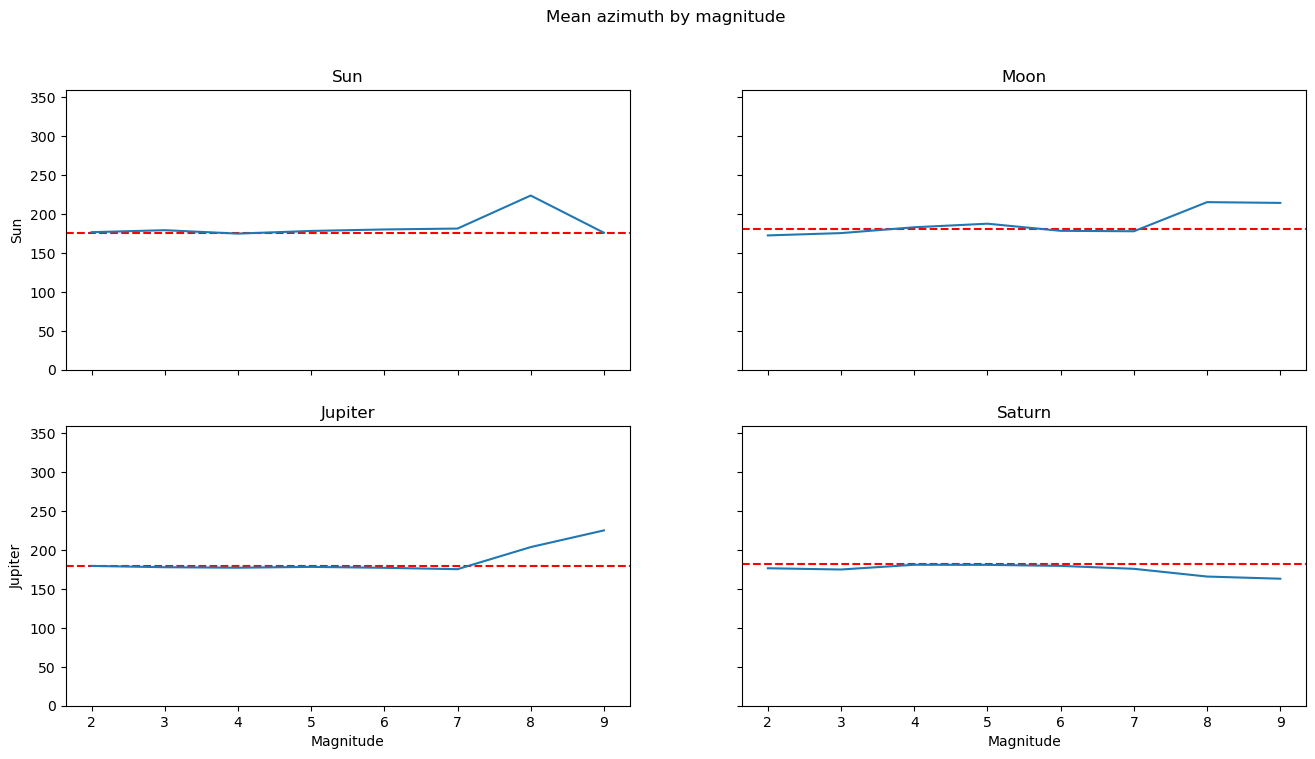

In [77]:
plt.clf()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharey=True, sharex=True, figsize=(16,8))
# fig.ylim(0, 360)
fig.suptitle('Mean azimuth by magnitude')
ax1.set_title('Sun')
ax1.axhline(y=control_mean_azi_by_mag.Sun[0], linestyle='dashed', color='r')
ax2.set_title('Moon')
ax2.axhline(y=control_mean_azi_by_mag.Moon[0], linestyle='dashed', color='r')
ax3.set_title('Jupiter')
ax3.axhline(y=control_mean_azi_by_mag.Jupiter[0], linestyle='dashed', color='r')
ax4.set_title('Saturn')
ax4.axhline(y=control_mean_azi_by_mag.Saturn[0], linestyle='dashed', color='r')
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(0,360)
sns.lineplot(ax=ax1, x=mean_azi_by_mag.index, y=mean_azi_by_mag.Sun)
sns.lineplot(ax=ax2, x=mean_azi_by_mag.index, y=mean_azi_by_mag.Moon)
sns.lineplot(ax=ax3, x=mean_azi_by_mag.index, y=mean_azi_by_mag.Jupiter)
sns.lineplot(ax=ax4, x=mean_azi_by_mag.index, y=mean_azi_by_mag.Saturn)
fig.savefig('./Visuals/MeanAzimuths.png', format='png')
plt.show();

# Visualize

<Figure size 640x480 with 0 Axes>

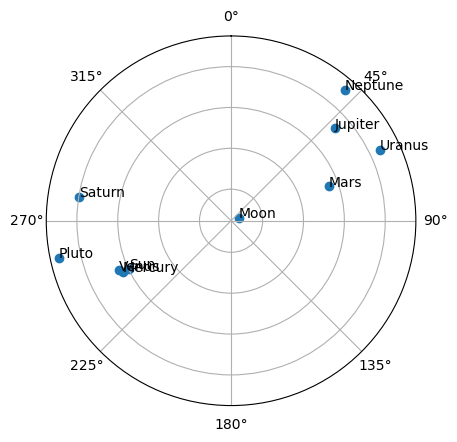

In [78]:
plot_event(core_with_separations['Event_6'])
# core_with_separations['Event_32']

<Figure size 640x480 with 0 Axes>

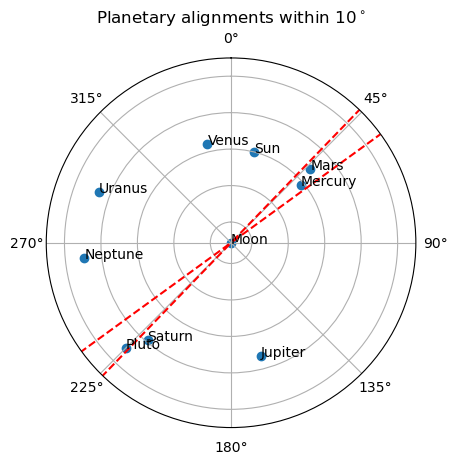

In [79]:
# Modified function to proudce presentation graphic

def display_plot(event, start_angle, window_angle):
        plt.clf()
        bodies = [body for body in event['astronomy']]

        r = []
        for body in bodies:
            r.append(math.log10(event['astronomy'][body]['distance']))

        theta = []
        # theta_see = []
        for body in bodies:
            theta.append(math.radians(event['astronomy'][body]['azimuth']))

        fig = plt.figure()
        ax = fig.add_subplot(projection='polar')
        ax.set_theta_direction(-1)
        ax.set_yticklabels([])
        ax.set_theta_zero_location('N')
        for i, body in enumerate(bodies):
            ax.annotate(body, (theta[i], r[i]))

        ax.scatter(theta, r)
        ax.plot([math.radians(start_angle), math.radians(start_angle)], [-2.5, 2.5], linestyle='--', c='r')
        ax.plot([math.radians(start_angle+window_angle), math.radians(start_angle+window_angle)], [-2.5, 2.5], linestyle='--', c='r')
        ax.plot([math.radians(180+start_angle), math.radians(180+start_angle)], [-2.5, 2.5], linestyle='--', c='r')
        ax.plot([math.radians(180+start_angle+window_angle), math.radians(180+start_angle+window_angle)], [-2.5, 2.5], linestyle='--', c='r')
        ax.margins(0)
        ax.set_title(f'Planetary alignments within {window_angle}$^\circ$')
        fig.savefig('./Visuals/AlignmentExample.png', format='png')
        plt.show();

display_plot(core_with_separations['Event_47'], 44, 10)

So what should my graphs look like, given a random distribution of events?    
0 Clustered seems in line: over a wide field it's almost impossible to not capture two and over a narrow field it happens very infrequently

In [80]:
x_SA = [int(item.split()[0]) for item in list(simple_alignments_ratios.columns)]*len(list(simple_alignments_ratios.index))
x_SA.sort()
y_SA = list(simple_alignments_ratios.index)*len(list(simple_alignments_ratios.columns))
z_SA = []
for column in simple_alignments_ratios.columns:
    z_SA += simple_alignments_ratios[column].to_list()
z_SA = [item/100 for item in z_SA]

In [81]:
x_CSA = [int(item.split()[0]) for item in list(control_simple_alignments_ratios.columns)]*len(list(control_simple_alignments_ratios.index))
x_CSA.sort()
y_CSA = list(control_simple_alignments_ratios.index)*len(list(control_simple_alignments_ratios.columns))
z_CSA = []
for column in control_simple_alignments_ratios.columns:
    z_CSA += control_simple_alignments_ratios[column].to_list()
z_CSA = [item/100 for item in z_CSA]

<Figure size 640x480 with 0 Axes>

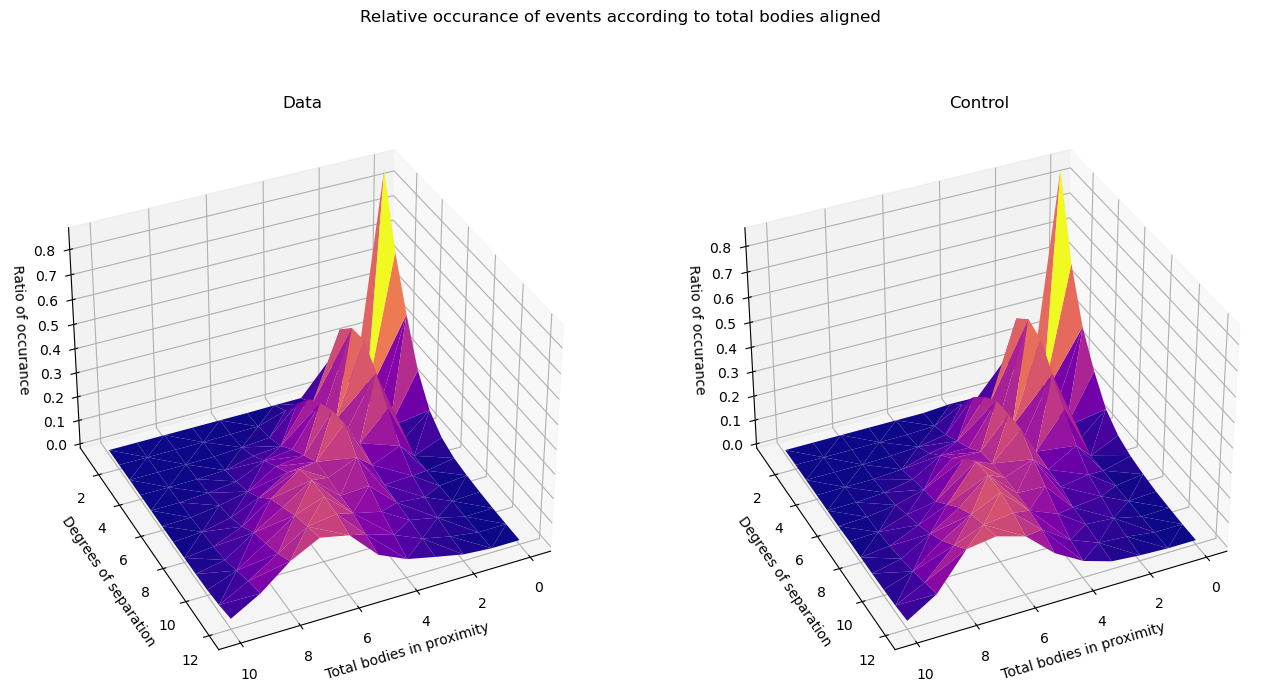

In [82]:
plt.clf()
fig, (ax, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='3d'), figsize=(16, 8))
ax.plot_trisurf(x_SA, y_SA, z_SA, cmap=plt.cm.plasma)
ax2.plot_trisurf(x_CSA, y_CSA, z_CSA, cmap=plt.cm.plasma)
fig.suptitle('Relative occurance of events according to total bodies aligned')
ax.set_title('Data')
ax2.set_title('Control')
for sub in [ax, ax2]:
    sub.set_xlabel('Total bodies in proximity')
    sub.set_ylabel('Degrees of separation')
    sub.set_zlabel('Ratio of occurance')
    sub.view_init(35, 65)

fig.savefig('./Visuals/SimpleAlignments.png', format='png')
plt.show();

In [83]:
x_SA_90 = [int(item.split()[0]) for item in list(simple_alignments_90_ratios.columns)]*len(list(simple_alignments_90_ratios.index))
x_SA_90.sort()
y_SA_90 = list(simple_alignments_90_ratios.index)*len(list(simple_alignments_90_ratios.columns))
z_SA_90 = []
for column in simple_alignments_90_ratios.columns:
    z_SA_90 += simple_alignments_90_ratios[column].to_list()
z_SA_90 = [item/100 for item in z_SA_90]

In [84]:
x_CSA_90 = [int(item.split()[0]) for item in list(control_simple_alignments_90_ratios.columns)]*len(list(control_simple_alignments_90_ratios.index))
x_CSA_90.sort()
y_CSA_90 = list(control_simple_alignments_90_ratios.index)*len(list(control_simple_alignments_90_ratios.columns))
z_CSA_90 = []
for column in control_simple_alignments_90_ratios.columns:
    z_CSA_90 += control_simple_alignments_90_ratios[column].to_list()
z_CSA_90 = [item/100 for item in z_CSA_90]

<Figure size 640x480 with 0 Axes>

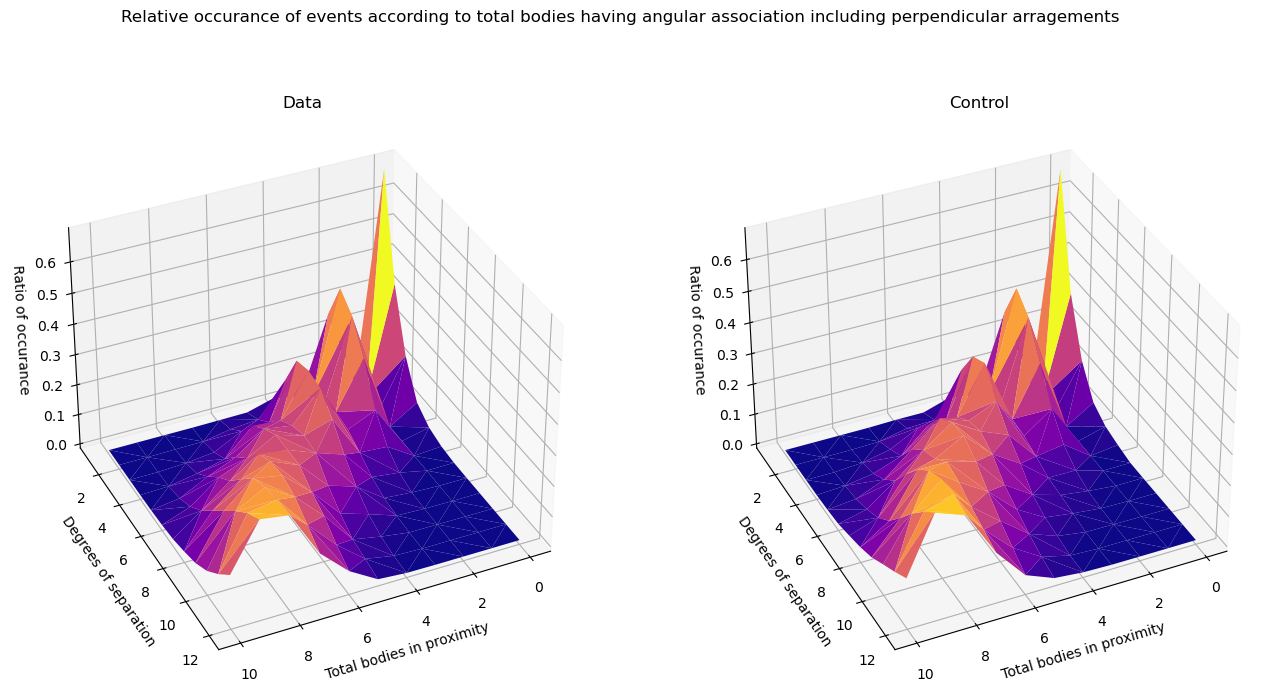

In [85]:
plt.clf()
fig, (ax, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='3d'), figsize=(16, 8))
ax.plot_trisurf(x_SA_90, y_SA_90, z_SA_90, cmap=plt.cm.plasma)
ax2.plot_trisurf(x_CSA_90, y_CSA_90, z_CSA_90, cmap=plt.cm.plasma)
fig.suptitle('Relative occurance of events according to total bodies having angular association including perpendicular arragements')
ax.set_title('Data')
ax2.set_title('Control')
for sub in [ax, ax2]:
    sub.set_xlabel('Total bodies in proximity')
    sub.set_ylabel('Degrees of separation')
    sub.set_zlabel('Ratio of occurance')
    sub.view_init(35, 65)

plt.show();

In [86]:
x_SC = [int(item.split()[0]) for item in list(simple_clustering_ratios.columns)]*len(list(simple_clustering_ratios.index))
x_SC.sort()
y_SC = list(simple_clustering_ratios.index)*len(list(simple_clustering_ratios.columns))
z_SC = []
for column in simple_clustering_ratios.columns:
    z_SC += simple_clustering_ratios[column].to_list()
z_SC = [item/100 for item in z_SC]

In [87]:
x_CSC = [int(item.split()[0]) for item in list(control_simple_clustering_ratios.columns)]*len(list(control_simple_clustering_ratios.index))
x_CSC.sort()
y_CSC = list(control_simple_clustering_ratios.index)*len(list(control_simple_clustering_ratios.columns))
z_CSC = []
for column in control_simple_clustering_ratios.columns:
    z_CSC += control_simple_clustering_ratios[column].to_list()
z_CSC = [item/100 for item in z_CSC]

<Figure size 640x480 with 0 Axes>

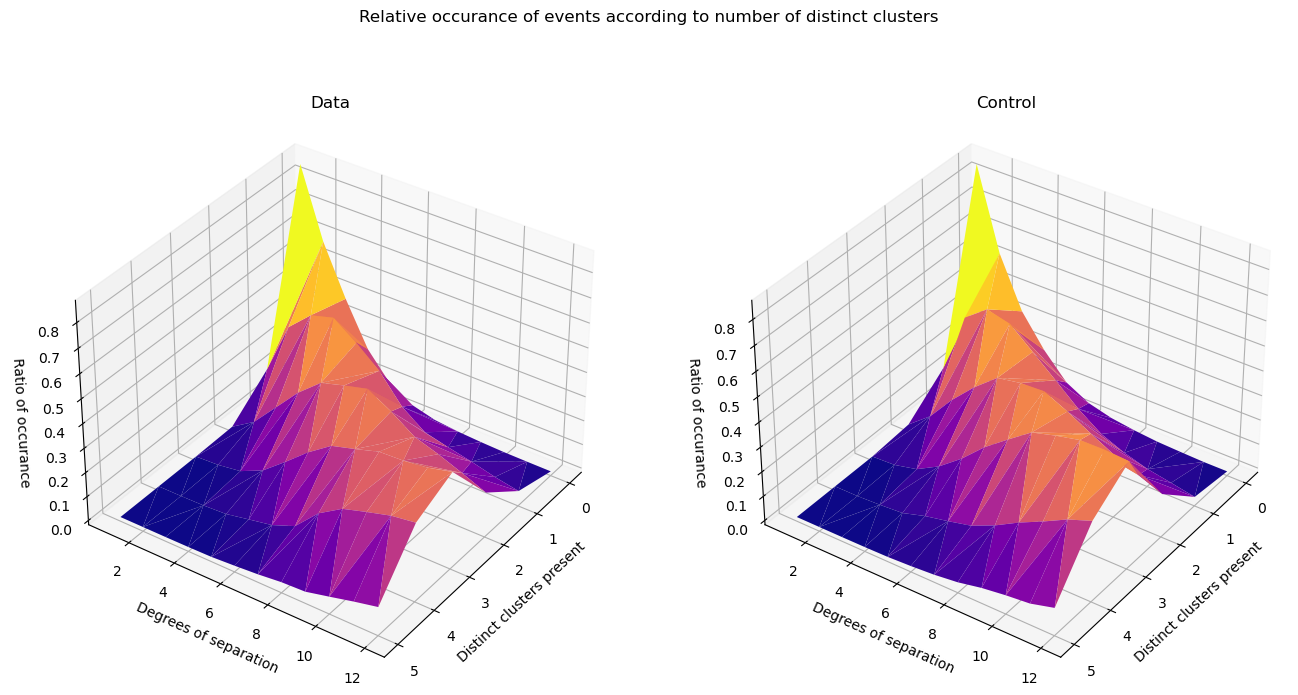

In [88]:
plt.clf()
fig, (ax, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='3d'), figsize=(16, 8))
ax.plot_trisurf(x_SC, y_SC, z_SC, cmap='plasma')
ax2.plot_trisurf(x_CSC, y_CSC, z_CSC, cmap='plasma')
fig.suptitle('Relative occurance of events according to number of distinct clusters')
ax.set_title('Data')
ax2.set_title('Control')
for sub in [ax, ax2]:
    sub.set_xlabel('Distinct clusters present')
    sub.set_ylabel('Degrees of separation')
    sub.set_zlabel('Ratio of occurance')
    sub.view_init(35, 35)
fig.savefig('./Visuals/SimpleClusters.png', format='png')
plt.show();

In [89]:
x_SC_90 = [int(item.split()[0]) for item in list(simple_clustering_90_ratios.columns)]*len(list(simple_clustering_90_ratios.index))
x_SC_90.sort()
y_SC_90 = list(simple_clustering_90_ratios.index)*len(list(simple_clustering_90_ratios.columns))
z_SC_90 = []
for column in simple_clustering_90_ratios.columns:
    z_SC_90 += simple_clustering_90_ratios[column].to_list()
z_SC_90 = [item/100 for item in z_SC_90]

In [90]:
x_CSC_90 = [int(item.split()[0]) for item in list(simple_clustering_90_ratios.columns)]*len(list(simple_clustering_90_ratios.index))
x_CSC_90.sort()
y_CSC_90 = list(simple_clustering_90_ratios.index)*len(list(simple_clustering_90_ratios.columns))
z_CSC_90 = []
for column in simple_clustering_90_ratios.columns:
    z_CSC_90 += simple_clustering_90_ratios[column].to_list()
z_CSC_90 = [item/100 for item in z_CSC_90]

<Figure size 640x480 with 0 Axes>

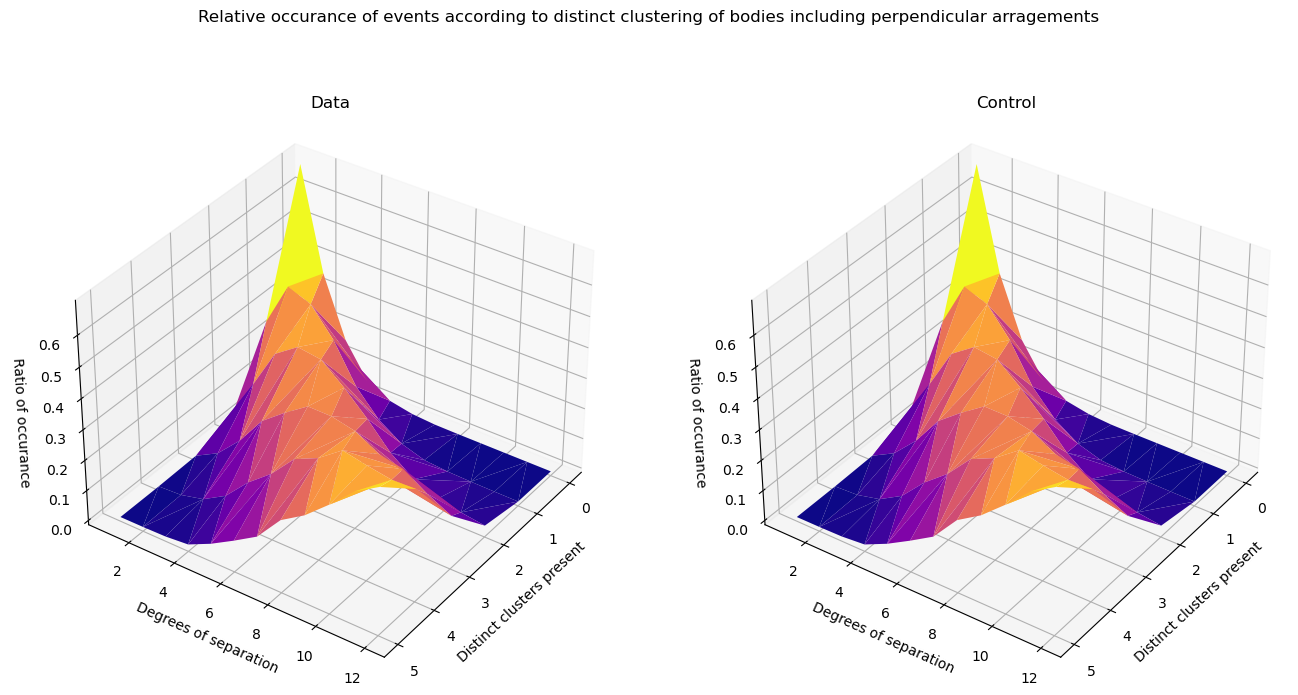

In [91]:
plt.clf()
fig, (ax, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='3d'), figsize=(16, 8))
ax.plot_trisurf(x_SC_90, y_SC_90, z_SC_90, cmap='plasma')
ax2.plot_trisurf(x_CSC_90, y_CSC_90, z_CSC_90, cmap='plasma')
fig.suptitle('Relative occurance of events according to distinct clustering of bodies including perpendicular arragements')
ax.set_title('Data')
ax2.set_title('Control')
for sub in [ax, ax2]:
    sub.set_xlabel('Distinct clusters present')
    sub.set_ylabel('Degrees of separation')
    sub.set_zlabel('Ratio of occurance')
    sub.view_init(35, 35)
plt.show();

# Single body azimuths

In [92]:
# lat = 57 + 27/60 + 26/3600
# lon = 13 + 32/60 + 24/3600
# then = '2022-03-03'
# today = '2023-03-03'
# test_time = '07%3A00%3A00'
# url = f"https://api.astronomyapi.com/api/v2/bodies/positions?longitude={lon}&latitude={lat}&elevation=0&from_date={then}&to_date={today}&time={test_time}"
# response = requests.get(url, headers=headers_ast)

# if response.status_code == 200:
#     one_year = response.json()

#     dates = []
#     azis = []
#     bodies = []

#     for i in [1, 6] :
#         for cell in one_year['data']['table']['rows'][i]['cells']:
#             dates.append(cell['date'].split('T')[0])
#             azis.append(cell['position']['horizontal']['azimuth']['degrees'])
#             bodies.append(one_year['data']['table']['rows'][i]['entry']['name'])

#     one_year_df = pd.DataFrame({'date': dates, 'azimuth': azis, 'body':bodies})
#     one_year_df['date'] = pd.to_datetime(one_year_df.date)
#     one_year_df['azimuth'] = pd.to_numeric(one_year_df.azimuth)

# else:
#     print(response.status_code)

In [93]:
# lat = 57 + 27/60 + 26/3600
# lon = 13 + 32/60 + 24/3600
# today = '2023-03-03'
# times = []
# azis = []
# bodies = []
# one_day = {}
# for hour in range(24):
#     for minute in ['00', '15', '30', '45']:
#         test_time = f'{hour}%3A{minute}%3A00'.rjust(12,'0')
#         url = f"https://api.astronomyapi.com/api/v2/bodies/positions?longitude={lon}&latitude={lat}&elevation=0&from_date={today}&to_date={today}&time={test_time}"
#         response = requests.get(url, headers=headers_ast)

#         if response.status_code == 200:
#             one_day[f'{hour}:{minute}'] = response.json()
#             for i in [1, 6]:
#                 times.append(one_day[f'{hour}:{minute}']['data']['table']['rows'][i]['cells'][0]['date'].split('T')[1][:8])
#                 azis.append(one_day[f'{hour}:{minute}']['data']['table']['rows'][i]['cells'][0]['position']['horizontal']['azimuth']['degrees'])
#                 bodies.append(one_day[f'{hour}:{minute}']['data']['table']['rows'][i]['entry']['name'])

#         else:
#             print(f'{hour}:{minute} - {response.status_code}')
# one_day_df = pd.DataFrame({'time': times, 'azimuth': azis, 'body': bodies})
# one_day_df['time'] = pd.to_datetime(one_day_df.time).dt.time
# one_day_df['azimuth'] = pd.to_numeric(one_day_df.azimuth)

In [94]:
# with open('./one_year.pickle', 'wb') as f:
#     pickle.dump(one_year, f)
# with open('./one_day.pickle', 'wb') as f:
#     pickle.dump(one_day, f)

In [95]:
with open('./one_year.pickle', 'rb') as f:
    one_year = pickle.load(f)

dates = []
azis = []
bodies = []

for i in [0, 1, 6] :
    for cell in one_year['data']['table']['rows'][i]['cells']:
        dates.append(cell['date'].split('T')[0])
        azis.append(cell['position']['horizontal']['azimuth']['degrees'])
        bodies.append(one_year['data']['table']['rows'][i]['entry']['name'])

one_year_df = pd.DataFrame({'date': dates, 'azimuth': azis, 'body':bodies})
one_year_df['date'] = pd.to_datetime(one_year_df.date)
one_year_df['azimuth'] = pd.to_numeric(one_year_df.azimuth)    
    

with open('./one_day.pickle', 'rb') as f:
    one_day = pickle.load(f)
times = []
azis = []
bodies = []

for hour in range(24):
    for minute in ['00', '15', '30', '45']:
        for i in [0, 1, 6]:
            times.append(one_day[f'{hour}:{minute}']['data']['table']['rows'][i]['cells'][0]['date'].split('T')[1][:8])
            azis.append(one_day[f'{hour}:{minute}']['data']['table']['rows'][i]['cells'][0]['position']['horizontal']['azimuth']['degrees'])
            bodies.append(one_day[f'{hour}:{minute}']['data']['table']['rows'][i]['entry']['name'])

one_day_df = pd.DataFrame({'time': times, 'azimuth': azis, 'body': bodies})
one_day_df['azimuth'] = pd.to_numeric(one_day_df.azimuth)

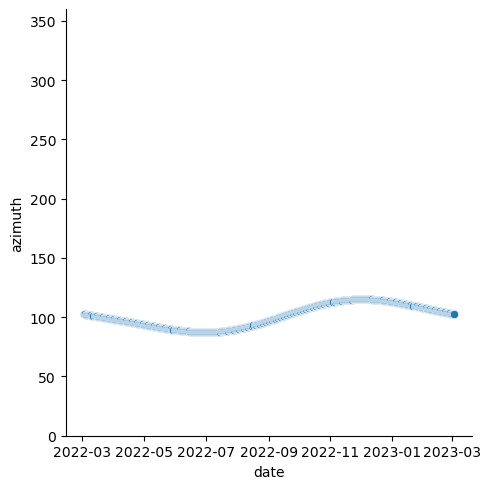

In [96]:
p =sns.relplot(data=one_year_df.loc[one_year_df.body == 'Sun'],
            x='date',
            y='azimuth',
            kind='scatter')
p.set(ylim=(0, 360))

<Figure size 640x480 with 0 Axes>

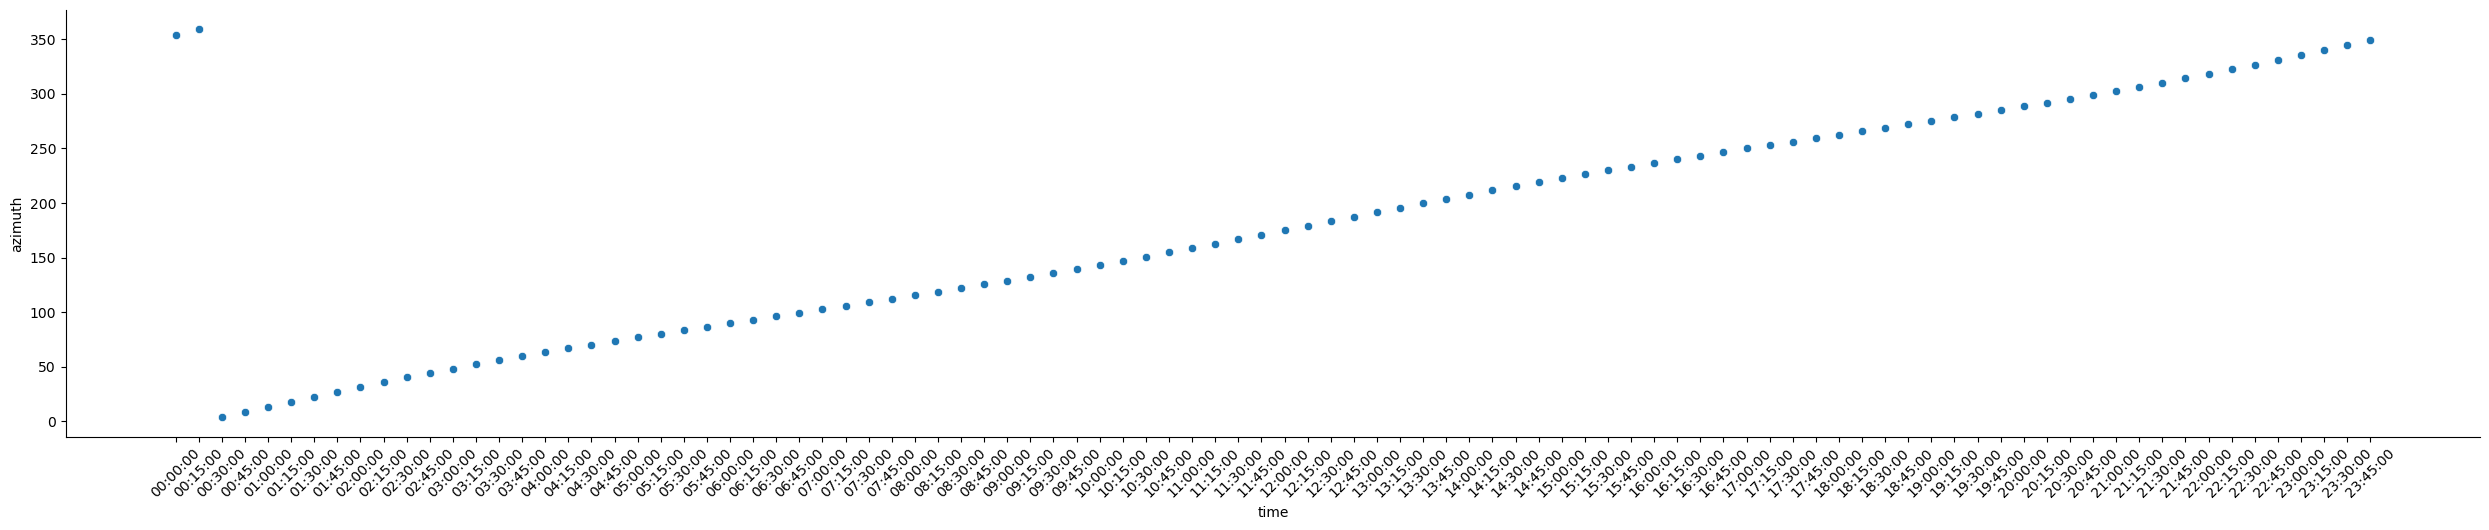

In [97]:
plt.clf()
sns.relplot(data=one_day_df.loc[one_day_df.body == 'Sun'],
            x='time',
            y='azimuth',
            kind='scatter',
            aspect=5)
plt.xticks(rotation=45)
plt.show();

# Statistics
* Null Hyphothesis: High magnitude earthquakes have planets randomly distributed (mean azimuth ~180 degrees)
* Alternative Hypothesis: Planets (some, not all) sit in a particular position in the sky during large earthquakes (mean azimuth != 180 degrees)

Due to the severe nature of earthquakes, a high degree of certainty is desired when identifying associations between earthquake timing and positions of heavenly bodies.    
Therefore, $\alpha$ is set relatively low, to 0.03

## Make Dataframes for looking at azimuth and altitude of bodies

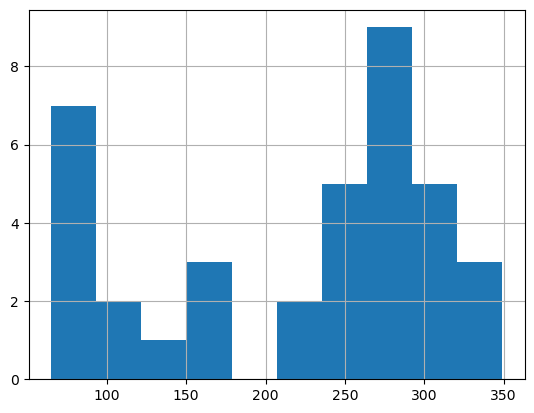

In [98]:
azimuths_df = pd.concat([make_azimuth_df(organized_core), make_azimuth_df(organized_asc)])
azimuths_df = pd.concat([azimuths_df, make_azimuth_df(organized_control_core)])
azimuths_df = pd.concat([azimuths_df, make_azimuth_df(organized_control_asc)])
azimuths_df['big'] = azimuths_df.magnitude.apply(lambda x: 1 if (x >= 8) else 0)
azimuths_df.loc[azimuths_df.big == 1].Sun.hist();

<AxesSubplot:>

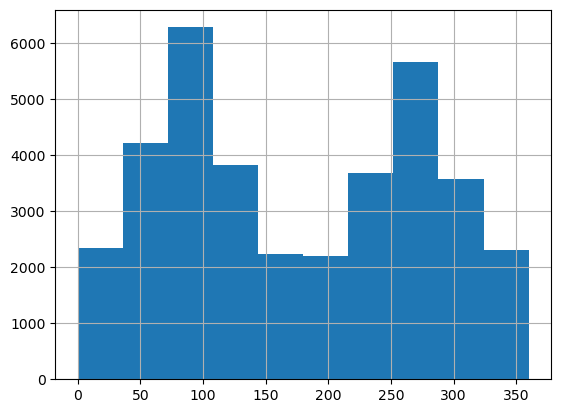

In [99]:
azimuths_df.Sun.hist()

In [100]:
altitudes_df = pd.concat([make_altitude_df(organized_core), make_altitude_df(organized_asc)])
altitudes_df = pd.concat([altitudes_df, make_altitude_df(organized_control_core)])
altitudes_df = pd.concat([altitudes_df, make_altitude_df(organized_control_asc)])
altitudes_df['big'] = altitudes_df.magnitude.apply(lambda x: 1 if (x >= 8) else 0)
altitudes_df

,magnitude,local_time,coordinates,Sun,Moon,Jupiter,Saturn,big
Event_0,7.5,2023-02-06#13:24:49,"[37.203, 38.0235, 10]",35.56,-34.49,40.22,38.14,0
Event_1,7.8,2023-02-06#04:17:34,"[37.0209, 37.2251, 10]",-38.41,43.90,-50.45,-44.78,0
Event_2,7.0,2023-01-18#15:06:11,"[127.0274, 2.7357, 28.855]",47.70,-2.19,62.06,70.51,0
Event_3,7.6,2023-01-10#02:47:35,"[130.0046, -7.0645, 105.2]",-44.58,62.70,-52.36,-67.86,0
Event_4,7.0,2023-01-08#23:32:42,"[166.8808, -14.9464, 29]",-51.99,43.13,-9.36,-37.58,0
...,...,...,...,...,...,...,...,...
Control_749_19,0.0,2009-07-13#04:37:44,"[-140.7046425924499, 74.62274303656997, 1]",14.12,18.50,0.41,-7.94,0
Control_749_20,0.0,2009-07-13#05:46:12,"[-139.4469878759868, 74.58921461252257, 1]",18.54,18.22,-2.21,-6.69,0
Control_749_21,0.0,2009-07-13#05:23:52,"[-138.7152249923507, 73.87779854442743, 1]",17.07,19.13,-0.79,-7.85,0
Control_749_22,0.0,2009-07-13#03:01:37,"[-140.03332978387706, 74.75924961836529, 1]",9.75,16.51,1.69,-7.18,0


In [101]:
separations_df = make_sun_separations_df(organized_core)
separations_df = pd.concat([separations_df, make_sun_separations_df(organized_asc)])
separations_df = pd.concat([separations_df, make_sun_separations_df(organized_control_core)])
separations_df = pd.concat([separations_df, make_sun_separations_df(organized_control_asc)])
separations_df['big'] = separations_df.magnitude.apply(lambda x: 1 if (x >= 8) else 0)

## Check variances and perform T tests

### Azimuth of bodies

In [102]:
bodies = ['Sun', 'Moon', 'Jupiter', 'Saturn']
azi_varchart = pd.DataFrame(columns=[0, 1], index=bodies)
for body in bodies:
    azi_varchart.loc[body, 0] = azimuths_df.loc[azimuths_df.big == 0][body].var()
    azi_varchart.loc[body, 1] = azimuths_df.loc[azimuths_df.big == 1][body].var()
azi_varchart

,0,1
Sun,10048.346876,7878.663758
Moon,9903.333326,9680.704227
Jupiter,9977.706672,7140.338965
Saturn,9211.561886,10986.572145


In [103]:
# alpha = .03
azi_pchart = pd.DataFrame(columns=['tscore', 'pvalue'], index=bodies)
for body in bodies:
    azi_pchart.loc[body, 'tscore'], azi_pchart.loc[body, 'pvalue'] = ttest_ind(a = azimuths_df.loc[azimuths_df.big == 0][body], b = azimuths_df.loc[azimuths_df.big == 1][body], alternative='two-sided', equal_var=False)


azi_pchart

# Significant difference in azimuth of the sun during magnitude 8+ events

,tscore,pvalue
Sun,-3.123796,0.003511
Moon,-2.116669,0.041253
Jupiter,-1.88045,0.068133
Saturn,0.872824,0.388534


### Azimuths of Sun for events preceding 8+ magnitude events

In [104]:
azimuths_significant_df = pd.DataFrame()
for event in azimuths_df.loc[azimuths_df.big == 1].index:
    azimuths_significant_df = pd.concat([azimuths_significant_df, azimuths_df.loc[azimuths_df.index.str.startswith(event+'_')]])

azimuths_significant_df

,magnitude,local_time,coordinates,Sun,Moon,Jupiter,Saturn,big
Event_23_0,4.9,2021-07-09#03:23:30,"[-26.3621, -57.8576, 122.51]",109.83,98.12,349.35,321.64,0
Event_23_1,4.5,2021-07-08#03:11:00,"[-24.9143, -59.2236, 10]",112.39,90.07,353.18,325.95,0
Event_23_2,4.6,2021-07-07#21:58:58,"[-24.4445, -57.8523, 10]",218.98,181.49,81.58,67.26,0
Event_23_3,5.0,2021-07-07#21:07:25,"[-24.6902, -57.9528, 10]",235.20,201.94,92.82,79.57,0
Event_23_4,4.4,2021-07-07#18:37:45,"[-24.3981, -57.9421, 10]",271.05,247.63,124.36,110.87,0
...,...,...,...,...,...,...,...,...
Event_558_26,5.0,1984-12-04#06:29:11,"[-71.682, -33.581, 54.6]",117.73,260.35,142.42,101.53,0
Event_558_27,4.4,1984-12-04#01:55:08,"[-71.418, -32.556, 53.5]",174.56,298.69,212.27,149.35,0
Event_558_28,5.1,1984-11-18#18:18:52,"[-71.814, -32.347, 42.2]",247.51,227.42,267.32,247.00,0
Event_558_29,4.6,1984-10-29#00:46:59,"[-72.363, -32.683, 33]",156.11,223.27,225.00,171.59,0


In [105]:
azi_sig_varchart = pd.DataFrame(columns=[0, 1], index=['Sun'])
azi_sig_varchart.loc['Sun', 0] = azimuths_df.loc[(azimuths_df.big == 0)&(~azimuths_df.index.isin(azimuths_significant_df.index))]['Sun'].var()
azi_sig_varchart.loc['Sun', 1] = azimuths_significant_df.Sun.var()
azi_sig_varchart

,0,1
Sun,10100.259519,8695.312778


In [106]:
azi_sig_pchart = pd.DataFrame(columns=['tscore', 'pvalue'], index=['Sun'])
for body in bodies:
    azi_sig_pchart.loc['Sun', 'tscore'], azi_sig_pchart.loc['Sun', 'pvalue'] = ttest_ind(a = azimuths_df.loc[(azimuths_df.big == 0)&(~azimuths_df.index.isin(azimuths_significant_df.index))]['Sun'], b = azimuths_significant_df['Sun'], alternative='two-sided', equal_var=False)

azi_sig_pchart

# No significant positioning of Sun during events leading up to magnitude 8+ events

,tscore,pvalue
Sun,-0.807081,0.419751


### Altitude of bodies

In [107]:
bodies = ['Sun', 'Moon', 'Jupiter', 'Saturn']
alt_varchart = pd.DataFrame(columns=[0, 1], index=bodies)
for body in bodies:
    alt_varchart.loc[body, 0] = altitudes_df.loc[altitudes_df.big == 0][body].var()
    alt_varchart.loc[body, 1] = altitudes_df.loc[altitudes_df.big == 1][body].var()
alt_varchart

,0,1
Sun,1433.310208,1509.187246
Moon,1418.787762,1606.26566
Jupiter,1380.905437,1770.063023
Saturn,1425.179014,1661.155182


In [108]:
# alpha = .03
alt_pchart = pd.DataFrame(columns=['tscore', 'pvalue'], index=bodies)
for body in bodies:
    alt_pchart.loc[body, 'tscore'], alt_pchart.loc[body, 'pvalue'] = ttest_ind(a = altitudes_df.loc[altitudes_df.big == 0][body], b = altitudes_df.loc[altitudes_df.big == 1][body], alternative='two-sided', equal_var=False)

alt_pchart

,tscore,pvalue
Sun,0.029941,0.976279
Moon,0.443746,0.659877
Jupiter,-1.909911,0.064125
Saturn,0.333412,0.740754


### Angular separation of bodies from the Sun

In [109]:
bodies = ['Moon', 'Jupiter', 'Saturn']
sep_varchart = pd.DataFrame(columns=[0, 1], index=bodies)
for body in bodies:
    sep_varchart.loc[body, 0] = separations_df.loc[separations_df.big == 0][body].var()
    sep_varchart.loc[body, 1] = separations_df.loc[separations_df.big == 1][body].var()
sep_varchart

,0,1
Moon,2635.72721,3131.456011
Jupiter,2649.029952,3239.222252
Saturn,2678.545335,2975.648417


In [110]:
# alpha = .03
sep_pchart = pd.DataFrame(columns=['tscore', 'pvalue'], index=bodies)
for body in bodies:
    sep_pchart.loc[body, 'tscore'], sep_pchart.loc[body, 'pvalue'] = ttest_ind(a = separations_df.loc[separations_df.big == 0][body], b = separations_df.loc[separations_df.big == 1][body], alternative='two-sided', equal_var=False)

sep_pchart

,tscore,pvalue
Moon,0.344621,0.732381
Jupiter,0.701508,0.487489
Saturn,-2.097943,0.042979


# Undeveloped

This section contains code for an unrealized analysis, based on indentifying which clusters (as in, which specific constellations of planets) are present during events,
and the relative frequency of those occurences. 

Left undeloped for time constraints; the clusters can be identified, but the method for determining significance is not yet developed.

In [111]:
active_clusters = pd.concat([identify_clusters(core_with_separations), identify_clusters(asc_with_separations)])
null_clusters = pd.concat([identify_clusters(control_core_with_separations), identify_clusters(control_asc_with_separations)])

In [112]:
active_set = set()
for item in active_clusters.to_numpy():
    for thing in item[0]:
        active_set.add(frozenset(thing))
active_set.remove(frozenset())

active_cluster_dict = {}
for i, thing in enumerate(active_set):
    n = 0
    for item in active_clusters.to_numpy():
        if thing in item[0]:
            n += 1
    active_cluster_dict[thing] = n
active_cluster_dict

{frozenset({'Jupiter', 'Mercury', 'Moon', 'Pluto', 'Sun'}): 1,
 frozenset({'Mars', 'Mercury', 'Moon', 'Sun'}): 13,
 frozenset({'Jupiter', 'Mars', 'Moon'}): 96,
 frozenset({'Moon', 'Neptune', 'Sun'}): 70,
 frozenset({'Mercury', 'Neptune', 'Sun', 'Uranus', 'Venus'}): 7,
 frozenset({'Jupiter', 'Saturn', 'Uranus'}): 128,
 frozenset({'Jupiter', 'Mercury', 'Pluto'}): 66,
 frozenset({'Moon', 'Saturn', 'Sun'}): 55,
 frozenset({'Moon', 'Sun'}): 831,
 frozenset({'Mars', 'Moon', 'Pluto'}): 51,
 frozenset({'Mercury', 'Neptune'}): 943,
 frozenset({'Mercury', 'Neptune', 'Saturn'}): 8,
 frozenset({'Mars', 'Uranus', 'Venus'}): 41,
 frozenset({'Saturn', 'Sun', 'Venus'}): 64,
 frozenset({'Neptune', 'Saturn', 'Venus'}): 57,
 frozenset({'Jupiter', 'Mercury'}): 1101,
 frozenset({'Moon', 'Pluto', 'Sun'}): 34,
 frozenset({'Jupiter', 'Mars', 'Mercury', 'Moon', 'Pluto', 'Sun'}): 1,
 frozenset({'Jupiter', 'Mars', 'Venus'}): 57,
 frozenset({'Jupiter', 'Mars', 'Mercury', 'Venus'}): 56,
 frozenset({'Mercury', 'Sat

In [113]:
null_set = set()
for item in null_clusters.to_numpy():
    for thing in item[0]:
        null_set.add(frozenset(thing))
null_set.remove(frozenset())

null_cluster_dict = {}
for i, thing in enumerate(null_set):
    n = 0
    for item in null_clusters.to_numpy():
        if thing in item[0]:
            n += 1
    null_cluster_dict[thing] = n
null_cluster_dict

{frozenset({'Mars', 'Mercury', 'Moon', 'Sun'}): 79,
 frozenset({'Jupiter', 'Mars', 'Pluto', 'Saturn'}): 77,
 frozenset({'Mercury', 'Moon', 'Venus'}): 134,
 frozenset({'Moon', 'Saturn', 'Uranus', 'Venus'}): 32,
 frozenset({'Moon', 'Neptune', 'Sun', 'Venus'}): 13,
 frozenset({'Jupiter', 'Mars', 'Moon', 'Neptune'}): 11,
 frozenset({'Saturn', 'Venus'}): 927,
 frozenset({'Saturn', 'Uranus', 'Venus'}): 145,
 frozenset({'Jupiter', 'Mars', 'Moon'}): 95,
 frozenset({'Mercury', 'Neptune', 'Venus'}): 25,
 frozenset({'Mars', 'Mercury', 'Neptune', 'Sun'}): 27,
 frozenset({'Moon', 'Neptune', 'Sun'}): 26,
 frozenset({'Jupiter', 'Mars', 'Mercury'}): 162,
 frozenset({'Mars', 'Moon', 'Neptune', 'Venus'}): 15,
 frozenset({'Jupiter', 'Mercury', 'Sun', 'Venus'}): 151,
 frozenset({'Jupiter', 'Saturn'}): 1111,
 frozenset({'Jupiter', 'Saturn', 'Uranus'}): 104,
 frozenset({'Jupiter', 'Neptune', 'Venus'}): 27,
 frozenset({'Mercury', 'Moon', 'Sun', 'Uranus'}): 52,
 frozenset({'Jupiter', 'Mars', 'Neptune', 'Uranu

In [114]:
diff_dict = {}
for ice in active_set.intersection(null_set):
    diff_dict[ice] = active_cluster_dict[ice]-null_cluster_dict[ice]
diff_dict

{frozenset({'Mars', 'Mercury', 'Moon', 'Sun'}): -66,
 frozenset({'Jupiter', 'Mars', 'Pluto', 'Saturn'}): -71,
 frozenset({'Mercury', 'Moon', 'Venus'}): -81,
 frozenset({'Moon', 'Saturn', 'Uranus', 'Venus'}): -22,
 frozenset({'Moon', 'Neptune', 'Sun', 'Venus'}): -8,
 frozenset({'Jupiter', 'Mars', 'Moon', 'Neptune'}): 3,
 frozenset({'Saturn', 'Venus'}): -90,
 frozenset({'Saturn', 'Uranus', 'Venus'}): -23,
 frozenset({'Jupiter', 'Mars', 'Moon'}): 1,
 frozenset({'Mercury', 'Neptune', 'Venus'}): 0,
 frozenset({'Mars', 'Mercury', 'Neptune', 'Sun'}): 8,
 frozenset({'Moon', 'Neptune', 'Sun'}): 44,
 frozenset({'Jupiter', 'Mars', 'Mercury'}): -31,
 frozenset({'Mars', 'Moon', 'Neptune', 'Venus'}): -8,
 frozenset({'Jupiter', 'Mercury', 'Sun', 'Venus'}): -92,
 frozenset({'Jupiter', 'Saturn'}): -314,
 frozenset({'Jupiter', 'Saturn', 'Uranus'}): 24,
 frozenset({'Jupiter', 'Neptune', 'Venus'}): 7,
 frozenset({'Mercury', 'Moon', 'Sun', 'Uranus'}): -32,
 frozenset({'Jupiter', 'Mars', 'Neptune', 'Uranus'